# SIS5203-41-Object-detection  
SKKU MLS lab.

In [86]:
import sys
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

True


In [87]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/MyDrive/Colab Notebooks/YOLO')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
!pip uninstall tensorflow

Found existing installation: tensorflow 1.14.0
Uninstalling tensorflow-1.14.0:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.14.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.14.0


In [89]:
!pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-1.14.0-cp37-cp37m-manylinux1_x86_64.whl (109.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.


In [90]:
!pip install keras==2.2.4
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
import warnings
warnings.simplefilter('ignore')

In [92]:
import tensorflow as tf
print(tf.__version__)  #1.14.0 에서 테스트됨

1.14.0


In [93]:
import os
import glob
import numpy as np
from IPython.display import display 
from PIL import Image
from yolo import YOLO
from PIL import Image, ImageFont, ImageDraw
import xml.etree.ElementTree as ET

### image, xml 파일 불러오기

In [94]:
img_files = sorted(glob.glob('./test_data/*.jpg'))
xml_files = sorted(glob.glob('./test_data/*.xml'))
print("파일개수:",np.shape(img_files)[0])

파일개수: 6


In [95]:
img_files[:3]

['./test_data/goalpost1.jpg',
 './test_data/goalpost21.jpg',
 './test_data/goalpost22.jpg']

In [96]:
def do_object_detection(file):
    image = Image.open(file)     # 이미지 로딩
    result_image, pred_box = yolo.detect_image(image)
    
    return result_image, pred_box

In [97]:
def do_load_xml(file):
    tree=ET.parse(file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if int(difficult)==1:
            continue
        xmlbox = obj.find('bndbox')
        real_box = [int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text)]
        
    return real_box

In [98]:
def draw_img(test_image, real_box, pred_box, iou):
    image = Image.open(test_image)
    fnt = ImageFont.truetype("./font/FiraMono-Medium.otf", 20)
    draw = ImageDraw.Draw(image)  
    
    if pred_box != []:
        # pred box
        draw.rectangle([(pred_box[0], pred_box[1]), (pred_box[2], pred_box[3])], outline ="red", width=5)
        draw.rectangle([(pred_box[0], pred_box[1]), (pred_box[0]+100, pred_box[1]-20)], fill ="red", width=5)
        draw_pred_text_pos = (pred_box[0]+3,pred_box[1]-20)
        draw.text(draw_pred_text_pos, 'Predict', fill='black',font=fnt)
        
        # iou 
        draw.rectangle([(0, 0), (180, 50)], fill='yellow')
        draw.text((10, 15), 'IoU : {}'.format(round(iou, 3)), font=fnt, fill ="black")
        #del draw

    # real box
    draw.rectangle([(real_box[0], real_box[1]), (real_box[2], real_box[3])], outline ="blue", width=5)
    draw.rectangle([(real_box[0], real_box[1]), (real_box[0]+150, real_box[1]-20)], fill ="blue", width=5)
    draw_real_text_pos = (real_box[0]+3,real_box[1]-20)
    draw.text(draw_real_text_pos, 'Ground Truth', fill='white',font=fnt)
    
    return image

### 학습된 model 불러오기

In [99]:
model_path = './predict/trained_weights_final.h5'
class_path = './predict/sports_classes.txt'

yolo = YOLO(model_path=model_path, classes_path=class_path)

./predict/trained_weights_final.h5 model, anchors, and classes loaded.


In [100]:
file_name = 'goalpost21' #### 테스트하려는 파일 이름으로 변경 (img, xml파일 이름 동일해야 함) ####

test_dir = './test_data'
test_img_file = '{}/{}.jpg'.format(test_dir, file_name)
test_xml_file = '{}/{}.xml'.format(test_dir, file_name)

image, pred_box = do_object_detection(test_img_file) # (1) 이미지 및 추론 결과, (2) bounding box 좌표

(416, 416, 3)
Found 1 boxes for img
goalpost 0.98 (55, 567) (2137, 1223)
time : 4.08 sec


In [101]:
image # (1) 이미지 및 추론 결과

Output hidden; open in https://colab.research.google.com to view.

In [102]:
pred_box = pred_box[0]
print(pred_box)  # (2) bounding box 좌표

[55, 567, 2137, 1223]


### xml 파일의 정답 박스(좌표 값) 불러오기

* real_box(파랑) : 실제 정답 box 
* pred_box(빨강) : 추론된 box

In [103]:
real_box = do_load_xml(test_xml_file)

In [104]:
real_box

[194, 513, 2049, 1227]

In [105]:
pred_box

[55, 567, 2137, 1223]

### IoU 구하기

과제입니다.  
입력으로 2개의 박스를 넣으면 2박스의 iou 값을 구해주는 함수를 작성하세요.   
현재는 -1을 출력하게 되어있습니다.
  
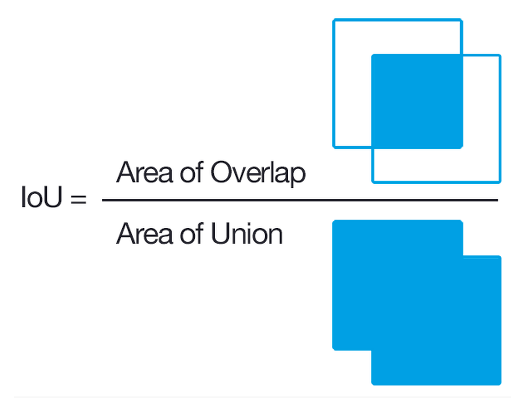

In [106]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [107]:
iou = IoU(real_box, pred_box)
print('iou :', round(iou, 3))

iou : 0.826


In [108]:
image = Image.open(test_img_file)
fnt = ImageFont.truetype("./font/FiraMono-Medium.otf", 20)

# pred box
draw = ImageDraw.Draw(image)  
draw.rectangle([(pred_box[0], pred_box[1]), (pred_box[2], pred_box[3])], outline ="red", width=5)
draw.rectangle([(pred_box[0], pred_box[1]), (pred_box[0]+100, pred_box[1]-20)], fill ="red", width=5)
draw_pred_text_pos = (pred_box[0]+3,pred_box[1]-20)
draw.text(draw_pred_text_pos, 'Predict', fill='black',font=fnt)

# real box
draw.rectangle([(real_box[0], real_box[1]), (real_box[2], real_box[3])], outline ="blue", width=5)
draw.rectangle([(real_box[0], real_box[1]), (real_box[0]+150, real_box[1]-20)], fill ="blue", width=5)
draw_real_text_pos = (real_box[0]+3,real_box[1]-20)
draw.text(draw_real_text_pos, 'Ground Truth', fill='white',font=fnt)

# iou 
draw.rectangle([(0, 0), (200, 50)], fill='yellow')
draw.text((10, 15), 'IoU : {}'.format(round(iou, 3)), font=fnt, fill ="black") 

In [ ]:
image

### 여러파일 테스트 예시

In [ ]:
test_all = True

In [ ]:
if test_all == True:
    for i in range(len(img_files)):  #len(img_files)
        print(img_files[i])
        result, pred_box = do_object_detection(img_files[i])
        if pred_box != []:
            pred_box = pred_box[0]
            real_box = do_load_xml(xml_files[i])
            iou = IoU(real_box, pred_box)
            print('iou :', round(iou, 3))
            result1 = draw_img(img_files[i], real_box, pred_box, iou)
            result1.save('./out/result_{}.jpg'.format(i))
            display(result1)
            
        else:
            real_box = do_load_xml(xml_files[i])
            result1 = draw_img(img_files[i], real_box, pred_box, iou)
            result1.save('./out/result_{}.jpg'.format(i))
            display(result1)